In [30]:
import pandas as pd
import re
import matplotlib.pyplot as plt

from string2string.alignment import LongestCommonSubsequence, LongestCommonSubstring
from string2string.distance import JaccardIndex
from string2string.misc.default_tokenizer import Tokenizer
import numpy as np

from sklearn.model_selection import train_test_split

In [10]:
generated = pd.read_csv("../data/generated_outputs.csv")
# generated = generated[temperatures].melt().rename({"variable": "temperature", "value": "text"}, axis=1)

In [11]:
original = pd.read_csv("../summaries.csv")

In [12]:
new = pd.read_csv("../data/processed_responses_with_predictions.csv").drop("HITId", axis=1)

In [13]:
qids = pd.read_csv("../data/qids.csv")

In [14]:
# temperatures = [str(k) for k in [0.3, 0.5, 0.7, 0.9, 1]]
temperatures = [str(k) for k in [0.7, 0.9]]

In [26]:
def extract_answer(text):
    pattern = r"<FreeText>(.*?)</FreeText>"
    matches = re.findall(pattern, text, re.DOTALL)

    return matches[1]
original["Answer"] = original["Answer"].apply(lambda x: extract_answer(x))

In [15]:
# generated["texts"] = generated["text"].apply(lambda x: x[4:20]).str.lower()
qids["question"] = qids["question"].apply(lambda x: x[4:20]).str.lower()

In [16]:
new["original_text"] = new["original_text"].apply(lambda x: x[4:20]).str.lower()

In [17]:
original = original[["Question", "Answer"]]

In [18]:
new

,original_text,key_strokes,datetime,text,copied,predicted
0,arison of weight,Backspace Delete,"['2023-05-29T22:30:57.844Z', '2023-05-29T22:31...",Because carbs usually provide over half of cal...,False,real
1,arison of weight,Control Control Control Control c c Control c ...,"['2023-05-29T20:58:29.931Z', '2023-05-29T20:58...",A study was conducted to compare the effective...,True,synthetic
2,arison of weight,ArrowLeft Backspace ArrowLeft ArrowLeft ArrowL...,"['2023-05-30T02:49:46.401Z', '2023-05-30T02:49...",This two-year study found that diets varying i...,True,synthetic
3,ct of screening,Control c Control v Control a Delete Control v...,"['2023-05-29T20:23:32.104Z', '2023-05-29T20:23...",Effect of Screening Mammography on Breast-Canc...,True,synthetic
4,ct of screening,CapsLock A CapsLock s t u d y i n CapsLock N C...,"['2023-05-29T18:40:24.249Z', '2023-05-29T18:40...",A study in Norway found that screening mammogr...,False,synthetic
5,ct of screening,Enter,['2023-05-29T18:23:15.814Z'],The Norwegian breast-cancer screening program ...,False,real
6,t results of pha,Backspace Backspace Backspace Backspace Backsp...,"['2023-05-29T18:24:22.677Z', '2023-05-29T18:24...",Exciting news from a study on a malaria vaccin...,False,real
7,t results of pha,Delete Delete Control v t h e 1 c h i s u s e ...,"['2023-05-29T18:19:27.221Z', '2023-05-29T18:19...","A phase 3 study of the malaria vaccine RTS, S/...",True,synthetic
8,t results of pha,Control v,"['2023-05-29T19:14:18.519Z', '2023-05-29T19:14...","A phase 3 trial of the RTS, S/AS01 malaria vac...",True,synthetic
9,hromycin and the,Control Control Control Control Control Contro...,"['2023-05-29T21:20:34.138Z', '2023-05-29T21:20...",Azithromycin is a broad-spectrum macrolide ant...,True,synthetic


In [19]:
new = new.merge(qids, left_on="original_text", right_on="question")[["HITId","text", "predicted"]]

In [20]:
# new = new[new["text"].map(len) > 150]

In [21]:
generated

,index,temperature,text,HITId
0,0,0.7,A study was conducted to compare the effective...,NEJMoa0804748
1,0,0.9,A study of 811 overweight adults has analyzed ...,NEJMoa0804748
2,0,0.7,A two-year study of 811 overweight adults foun...,NEJMoa0804748
3,0,0.9,A study has looked into whether a diet that em...,NEJMoa0804748
4,0,0.7,A study has been conducted to determine the ef...,NEJMoa0804748
...,...,...,...,...
315,15,0.9,"High sodium intake, which increases blood pres...",NEJMoa1304127
316,15,0.7,High sodium intake is a known risk factor for ...,NEJMoa1304127
317,15,0.9,A new study published in the New England Journ...,NEJMoa1304127
318,15,0.7,High levels of sodium consumption are responsi...,NEJMoa1304127


In [55]:
def prepare_for_finetuning(gen, real):
    real = real.rename({"Question":"HITId", "Answer":"text"}, axis=1)
    gen = gen[["HITId", "text"]]
    
    # add labels
    real["labels"] = "real"
    gen["labels"] = "synthetic"
    
    return pd.concat([real, gen], axis=0).sample(frac=1)


for_training = prepare_for_finetuning(generated, original)


/tmp/ipykernel_2799387/849739118.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gen["labels"] = "synthetic"


In [56]:
all_questions = list(for_training["HITId"].unique())
train_questions = np.random.choice(all_questions, 12)
q_set = set(all_questions)
test_questions = list(q_set - set(train_questions))

In [61]:
train = for_training[for_training["HITId"].isin(train_questions)][["text", "labels"]]
test = for_training[for_training["HITId"].isin(test_questions)][["text", "labels"]]

In [66]:
mapping = {"synthetic": 0, "real": 1}

In [69]:
labels = ["synthetic", "real"]

In [73]:
def _label_preprocessing(label):
    """Preprocessing the labels"""

    if isinstance(label, int):
        label = idx_to_label_mapper()[label]

    label_list = [0] * len(labels)
    label_list[labels.index(label)] = 1
    return label_list


def label_to_idx_mapper():
    assert labels is not None, "Labels are not set"

    return {label: idx for idx, label in enumerate(labels)}

In [ ]:
self.data = self.data.map(
        lambda x: {"float_labels": x["labels"].to(torch.float)},
        remove_columns=["labels"],
    ).rename_column("float_labels", "labels")

In [79]:
import torch

for idx, item in train.iterrows():
    label = item['labels']
    print(f'Item #{idx}, Label type: {type(_label_preprocessing(label))}')

    if isinstance(label, int):
        try:
            item['labels'] = torch.tensor(_label_preprocessing(label), dtype=torch.float32)
        except TypeError as e:
            print(f"Error occurred at item #{idx}: {e}")
    else:
        print(f"Unexpected type at item #{idx}, expected int, got {type(label)}. Skipping conversion...")

Item #117, Label type: <class 'list'>
Unexpected type at item #117, expected int, got <class 'str'>. Skipping conversion...
Item #197, Label type: <class 'list'>
Unexpected type at item #197, expected int, got <class 'str'>. Skipping conversion...
Item #209, Label type: <class 'list'>
Unexpected type at item #209, expected int, got <class 'str'>. Skipping conversion...
Item #179, Label type: <class 'list'>
Unexpected type at item #179, expected int, got <class 'str'>. Skipping conversion...
Item #164, Label type: <class 'list'>
Unexpected type at item #164, expected int, got <class 'str'>. Skipping conversion...
Item #125, Label type: <class 'list'>
Unexpected type at item #125, expected int, got <class 'str'>. Skipping conversion...
Item #110, Label type: <class 'list'>
Unexpected type at item #110, expected int, got <class 'str'>. Skipping conversion...
Item #114, Label type: <class 'list'>
Unexpected type at item #114, expected int, got <class 'str'>. Skipping conversion...
Item #21

In [62]:
# train, test = train_test_split(for_training)

In [63]:
train.to_json("../data/train.json", orient="records", indent=2)
test.to_json("../data/test.json", orient="records", indent=2)

In [60]:
# generated = generated[generated["variable"].str.contains("0.7|1")]

In [691]:
drop = [20,22, 26, 47]

In [692]:
new = new[~new.index.isin(drop)]

In [40]:
def measure_subseq_length(gen, k):
#     lcsubsequence = LongestCommonSubstring()
    lcsubsequence = LongestCommonSubsequence()
    
    tokenizer = Tokenizer(word_delimiter=' ')

    gen_token = tokenizer.tokenize(gen)
    k_token = tokenizer.tokenize(k)
    
    
    length, candidates = lcsubsequence.compute(
        str1=gen_token,
        str2=k_token,
        returnCandidates=False,
    )
    return length 

In [41]:
def measure_substr_length(gen, k):
    lcsubsequence = LongestCommonSubstring()
    
    tokenizer = Tokenizer(word_delimiter=' ')

    gen_token = tokenizer.tokenize(gen)
    k_token = tokenizer.tokenize(k)
    
    
    length, candidates = lcsubsequence.compute(
        str1=gen_token,
        str2=k_token,
        returnCandidates=False,
    )
    return length 

In [42]:
def measure_jaccard_sim(gen, k):
#     lcsubsequence = LongestCommonSubstring()
    jaccard_distance = JaccardIndex()
    
    tokenizer = Tokenizer(word_delimiter=' ')

    gen_token = tokenizer.tokenize(gen)
    k_token = tokenizer.tokenize(k)
    
    
    jaccard_dist_score = jaccard_distance.compute(gen_token, k_token)

    return jaccard_dist_score

In [43]:
ids = new["HITId"].unique()

In [47]:
new_sim = []
original_sim = []

for idx in ids:
    new_ = new[new["HITId"] == idx]
    original_ = original[original["Question"] == idx]
    generated_ = generated[generated["HITId"] == idx]
    
    for i, row in generated_.iterrows():
        gen_text = row["text"]
        for j, row2 in new_.iterrows():
            summary = row2["text"]
            new_sim.append([idx, measure_subseq_length(gen_text, summary)])
        for j, row2 in original_.iterrows():
            summary = row2["Answer"]
            original_sim.append([idx, measure_subseq_length(gen_text, summary)])
        

In [51]:
new_sub_sim = []
original_sub_sim = []

for idx in ids:
    new_ = new[new["HITId"] == idx]
    original_ = original[original["Question"] == idx]
    generated_ = generated[generated["HITId"] == idx]
    
    for i, row in generated_.iterrows():
        gen_text = row["text"]
        for j, row2 in new_.iterrows():
            summary = row2["text"]
            new_sub_sim.append([idx, measure_substr_length(gen_text, summary)])
        for j, row2 in original_.iterrows():
            summary = row2["Answer"]
            original_sub_sim.append([idx, measure_substr_length(gen_text, summary)])
        

In [53]:
new_jaccard_sim = []
original_jaccard_sim = []

for idx in ids:
    new_ = new[new["HITId"] == idx]
    original_ = original[original["Question"] == idx]
    generated_ = generated[generated["HITId"] == idx]
    
    for i, row in generated_.iterrows():
        gen_text = row["text"]
        for j, row2 in new_.iterrows():
            summary = row2["text"]
            new_jaccard_sim.append([idx, measure_jaccard_sim(gen_text, summary)])
        for j, row2 in original_.iterrows():
            summary = row2["Answer"]
            original_jaccard_sim.append([idx, measure_jaccard_sim(gen_text, summary)])
        

In [54]:
og_sim = pd.DataFrame(original_sim)
new_sim = pd.DataFrame(new_sim)

In [60]:
new_sim["copied"] = new["predicted"]

In [61]:
og_j = pd.DataFrame(original_jaccard_sim)
new_j = pd.DataFrame(new_jaccard_sim)

In [62]:
new_j["copied"] = new["predicted"]

In [63]:
og_s = pd.DataFrame(original_sub_sim)
new_s = pd.DataFrame(new_sub_sim)

In [64]:
new_s["copied"] = new["predicted"]

In [565]:
new_sim[1].mean()

36.256410256410255

In [566]:
og_sim[1].mean()

37.015625

Text(0.5, 0, 'Longest matching subsequence')

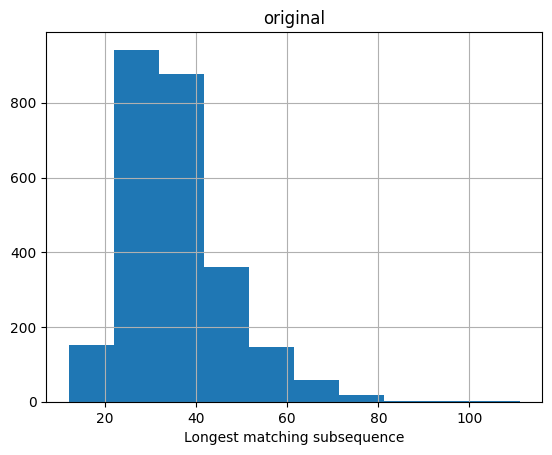

In [65]:
og_sim[og_sim[1]>0.01].rename({1: "original"}, axis=1).hist()
plt.xlabel("Longest matching subsequence")

Text(0.5, 0, 'Longest matching subsequence')

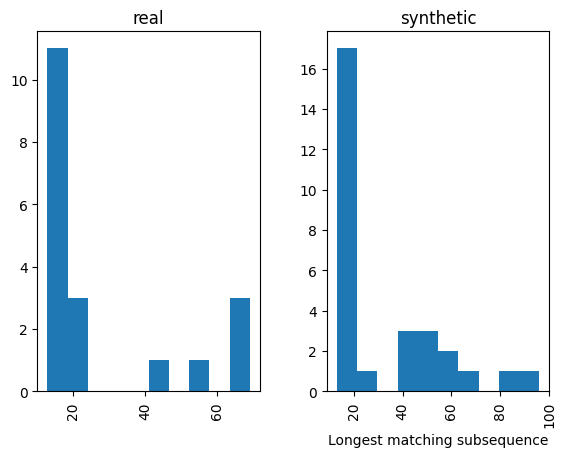

In [66]:
new_sim[new_sim[1]>0.01].rename({1: "new"}, axis=1).hist(by="copied")
plt.xlabel("Longest matching subsequence")

Text(0.5, 0, 'Jaccard')

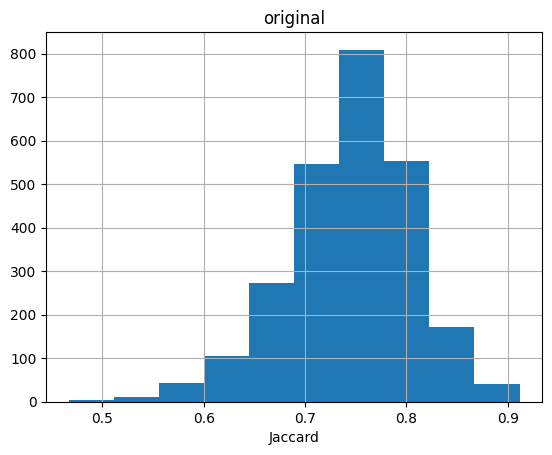

In [67]:
og_j[og_j[1]>0.01].rename({1: "original"}, axis=1).hist()
plt.xlabel("Jaccard")

Text(0.5, 0, 'Jaccard')

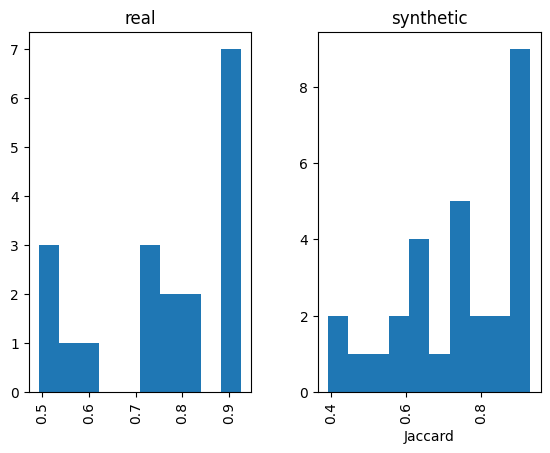

In [68]:
new_j[new_j[1]>0.01].rename({1: "new"}, axis=1).hist(by="copied")
plt.xlabel("Jaccard")

Text(0.5, 0, 'Longest matching substring')

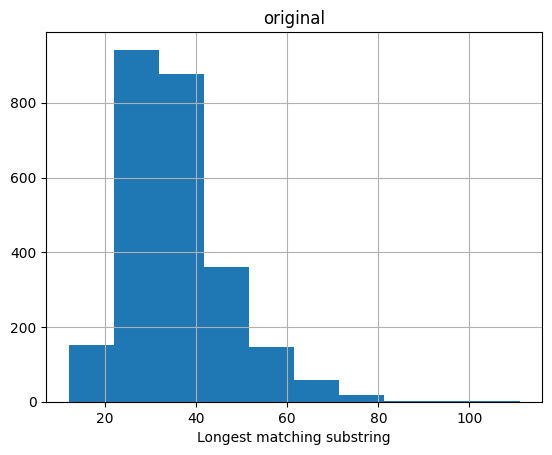

In [69]:
og_sim[og_sim[1]>0.01].rename({1: "original"}, axis=1).hist()
plt.xlabel("Longest matching substring")

Text(0.5, 0, 'Longest matching substring')

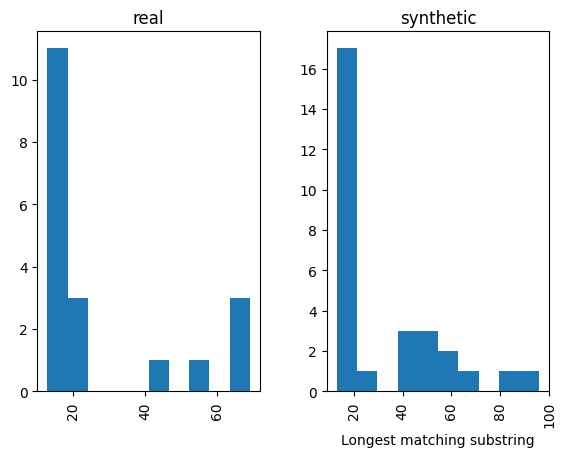

In [70]:
new_sim[new_sim[1]>0.01].rename({1: "new"}, axis=1).hist(by="copied")
plt.xlabel("Longest matching substring")